<h1> Coursera Capstone - Opening a Coffee shop</h1>

## Introduction
I always wanted to open a coffee place, but the rent prices in Munich are extremly high. 
Therefore, I need to select a Borough which satisfies my limitations.
Thus, I need to find the place where a coffee would be a popular local inr, the rent prices are low and the density of population is enough to sustain an additional coffee place.

## Data



A table with date of Boroughs in Munich can be found at [https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens]. This includes
Name of Borough, surface area, inhabitants, density and percentage of foreigner

We can obtain the data related to population and rent prices for each Borough of Munich from the inmobiliaries 
[https://suedbayerische-immobilien.de/Mietpreise-Muenchen-Stadtteile]


The geographic coordinates of each Borough can be obtained from a GeoJSON file in [https://stekhn.carto.com/tables/munich/public/map].

Additionaly Foursquare can be used to find popular venues close to each of the Boroughs. A difficulty might be the sparsity of information on Foursquare, since Foursquare is not very popular in Germany.


Using all this I suld be able to find the optimun Borough where I can open my coffee place.



# Part 1/4

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium 
from folium import plugins
from geopy.geocoders import Nominatim
import json


print ("Hello Capstone Project Course!")

Hello Capstone Project Course!


In this work we would like to see if it is possible to cluster the locals according to the rent price cluster seen in the city (which is correlated to the average income of the inhabitants)

In [2]:
res = requests.get("https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens")
soup = BeautifulSoup(res.content, 'html')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]


## Change (translate the names of the columns)
Edit the columns name and eliminate unecessary tables

In [3]:
df.drop(25, axis=0, inplace=True)
df.drop(26, axis=0, inplace=True)
df.columns = ['Number', 'Boroughs', 'Surface (km^2)', 'Inhabitants', 'Density (inhabitants/km^2)', 'Foreigners %' ]
df['Surface (km^2)'] = df['Surface (km^2)'].apply(lambda x: x/100)
df['Foreigners %'] = df['Foreigners %'].apply(lambda x: x/10)
df.drop('Number', axis=1, inplace=True)

In [4]:
df.head()

,Boroughs,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %
0,Altstadt-Lehel,3.15,21.454,6.820,27.4
1,Ludwigsvorstadt-Isarvorstadt,4.40,54.915,12.477,32.6
2,Maxvorstadt,4.30,53.443,12.435,27.9
3,Schwabing-West,4.36,69.407,15.908,23.4
4,Au-Haidhausen,4.22,61.999,14.693,24.7


Obtain data about the rent prices in the Boroughs

In [4]:
res = requests.get("https://suedbayerische-immobilien.de/Mietpreise-Muenchen-Stadtteile")
soup = BeautifulSoup(res.content, 'html')
table = soup.find_all('table')[1]
df_price = pd.read_html(str(table))[0]

Format the imported data

In [5]:
df_price.columns = ['Boroughs',  'Rent price EUR/m^2' ]
df_price['Rent price EUR/m^2'] = df_price['Rent price EUR/m^2'].apply(lambda x: x/10)
new_values = ['Ludwigsvorstadt-Isarvorstadt','Altstadt-Lehel','Maxvorstadt','Schwabing-West','Schwanthalerhöhe' 
                           ,'Au-Haidhausen','Neuhausen-Nymphenburg','Schwabing-Freimann','Bogenhausen','Milbertshofen-Am Hart'
                           ,'Laim','Sendling','Moosach','Untergiesing-Harlaching','Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln'
                           , 'Sendling-Westpark','Pasing-Obermenzing','Obergiesing-Fasangarten','Hadern','Berg am Laim','Ramersdorf-Perlach'
                           ,'Trudering-Riem','Allach-Untermenzing','Feldmoching-Hasenbergl' ,'Aubing-Lochhausen-Langwied'] 
df_price.loc[:,'Boroughs']= new_values
df_price.loc[df_price['Boroughs']=='Sendling','Rent price EUR/m^2']=10*df_price.loc[df_price['Boroughs']=='Sendling','Rent price EUR/m^2']
df_price.loc[df_price['Boroughs']=='Moosach','Rent price EUR/m^2']=10*df_price.loc[df_price['Boroughs']=='Moosach','Rent price EUR/m^2']
df_price.loc[df_price['Boroughs']=='Sendling-Westpark','Rent price EUR/m^2']=10*df_price.loc[df_price['Boroughs']=='Sendling-Westpark','Rent price EUR/m^2']
df_price.loc[df_price['Boroughs']=='Allach-Untermenzing','Rent price EUR/m^2']=10*df_price.loc[df_price['Boroughs']=='Allach-Untermenzing','Rent price EUR/m^2']
df_price.loc[df_price['Boroughs']=='Feldmoching-Hasenbergl','Rent price EUR/m^2']=10*df_price.loc[df_price['Boroughs']=='Feldmoching-Hasenbergl','Rent price EUR/m^2']

We merge both dataframes according to the Borough

In [6]:
df_Munich = pd.merge(df, df_price, on=['Boroughs','Boroughs'])

In [8]:
df_Munich.head()

,Boroughs,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2
0,Altstadt-Lehel,3.15,21.454,6.820,27.4,15.3
1,Ludwigsvorstadt-Isarvorstadt,4.40,54.915,12.477,32.6,16.4
2,Maxvorstadt,4.30,53.443,12.435,27.9,15.2
3,Schwabing-West,4.36,69.407,15.908,23.4,15.2
4,Au-Haidhausen,4.22,61.999,14.693,24.7,15.1


In [7]:
df_Munich['Inhabitants']=df_Munich['Inhabitants'].str.replace('.', '')
df_Munich['Inhabitants']=df_Munich['Inhabitants'].astype(int)

In [10]:
df_Munich.dtypes

Boroughs                       object
Surface (km^2)                float64
Inhabitants                     int64
Density (inhabitants/km^2)    float64
Foreigners %                  float64
Rent price EUR/m^2            float64
dtype: object

In [11]:
df_Munich

,Boroughs,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2
0,Altstadt-Lehel,3.15,21454,6.820,27.4,15.3
1,Ludwigsvorstadt-Isarvorstadt,4.40,54915,12.477,32.6,16.4
2,Maxvorstadt,4.30,53443,12.435,27.9,15.2
3,Schwabing-West,4.36,69407,15.908,23.4,15.2
4,Au-Haidhausen,4.22,61999,14.693,24.7,15.1
5,Sendling,3.94,41230,10.468,27.5,14.0
6,Sendling-Westpark,7.81,59175,7.572,28.8,13.0
7,Schwanthalerhöhe,2.07,30282,14.628,34.7,15.2
8,Neuhausen-Nymphenburg,12.91,99538,7.707,25.0,15.1
9,Moosach,11.09,53859,4.855,30.8,14.0


# Part 2/4: Cloropleth map

Ilustrative map of Munich

In [8]:
address = 'Munich'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Munich are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Munich are 48.1371079, 11.5753822.


In [9]:
munich_map = folium.Map(location=[latitude, longitude], zoom_start=11)
fs = plugins.Fullscreen()
munich_map.add_child(fs)
folium.GeoJson('munich.geojson').add_to(munich_map)
munich_map

In [10]:
munich_geo = r'munich.geojson' # geojson

In [11]:
boroughs=dict()
boroughs_names = list()

In [12]:
with open(munich_geo) as f:
    data = json.load(f)

In [13]:
for feature in data['features']:
    name = feature['properties']['name']
    coordinates = feature['geometry']['coordinates']
    boroughs[name] = coordinates[:][0][0]
    boroughs_names.append(name)

In [14]:
boroughs_coordinates=dict()

In [15]:
for x in boroughs:
    boroughs[x] 
    boroughs_coordinates[x]= np.mean(boroughs[x], axis = 0)

In [16]:
boroughs_coordinates_df = pd.DataFrame(boroughs_coordinates)

In [17]:
boroughs_coordinates_df

,Berg am Laim,Schwanthalerhöhe,Altstadt-Lehel,Allach-Untermenzing,Hadern,Au-Haidhausen,Pasing-Obermenzing,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwabing-West,...,Neuhausen-Nymphenburg,Feldmoching-Hasenbergl,Aubing-Lochhausen-Langwied,Bogenhausen,Sendling-Westpark,Ramersdorf-Perlach,Untergiesing-Harlaching,Obergiesing-Fasangarten,Schwabing-Freimann,Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
0,11.623498,11.540085,11.581973,11.467160,11.472252,11.596434,11.461062,11.563565,11.565119,11.582597,...,11.520135,11.514623,11.396575,11.656945,11.532969,11.657549,11.558206,11.587845,11.621297,11.508085
1,48.124306,48.136428,48.141517,48.195986,48.115026,48.132382,48.150236,48.132509,48.148948,48.162530,...,48.158494,48.230878,48.162181,48.166891,48.113591,48.094332,48.083134,48.096393,48.206540,48.082995


In [18]:
boroughs_coordinates_df = boroughs_coordinates_df.transpose() 

In [19]:
boroughs_coordinates_df.reset_index(level=0, inplace=True)

In [20]:
boroughs_coordinates_df.columns = [ 'Boroughs', 'longitude','latitude' ]

In [22]:
boroughs_coordinates_df

,Boroughs,longitude,latitude
0,Berg am Laim,11.623498,48.124306
1,Schwanthalerhöhe,11.540085,48.136428
2,Altstadt-Lehel,11.581973,48.141517
3,Allach-Untermenzing,11.467160,48.195986
4,Hadern,11.472252,48.115026
5,Au-Haidhausen,11.596434,48.132382
6,Pasing-Obermenzing,11.461062,48.150236
7,Ludwigsvorstadt-Isarvorstadt,11.563565,48.132509
8,Maxvorstadt,11.565119,48.148948
9,Schwabing-West,11.582597,48.162530


In [21]:
boroughs_names_df = pd.merge(boroughs_coordinates_df,df_Munich, on=['Boroughs','Boroughs' ] )

In [22]:
boroughs_names_df
boroughs_names_df.dtypes

Boroughs                       object
longitude                     float64
latitude                      float64
Surface (km^2)                float64
Inhabitants                     int64
Density (inhabitants/km^2)    float64
Foreigners %                  float64
Rent price EUR/m^2            float64
dtype: object

In [23]:
munich_map = folium.Map(location=[latitude, longitude], zoom_start=11)
fs = plugins.Fullscreen()
munich_map.add_child(fs)

folium.GeoJson('munich.geojson').add_to(munich_map)

munich_map.choropleth(
    geo_data='munich.geojson',
    name='Population Density',
    data=boroughs_names_df,
    columns=['Boroughs', 'Density (inhabitants/km^2)'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Density'
)

munich_map

# Part 3/4

Extracting data from Foursquare for each Borough

In [24]:
map_munich2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough in zip(boroughs_names_df['latitude'], boroughs_names_df['longitude'], boroughs_names_df['Boroughs']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich2)  
    
map_munich2

In [25]:
# @hidden cell 
CLIENT_ID = 'IVWSCKFLJHUL1S5V3IDAT3FCDP1I2P1C3JU23ONGV13JHCVH' # your Foursquare ID
CLIENT_SECRET = 'DNROFNL5OIG1YH4VY550VICBJPREZ5UVZE5G45YUVV3CCIDM' # your Foursquare Secret
VERSION = '20190621' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IVWSCKFLJHUL1S5V3IDAT3FCDP1I2P1C3JU23ONGV13JHCVH
CLIENT_SECRET:DNROFNL5OIG1YH4VY550VICBJPREZ5UVZE5G45YUVV3CCIDM


In [26]:
LIMIT = 100
radius = 1000
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
Munich_venues = getNearbyVenues(names=boroughs_names_df['Boroughs'],
                                   latitudes=boroughs_names_df['latitude'],
                                   longitudes=boroughs_names_df['longitude']
                                  )

Berg am Laim
Schwanthalerhöhe
Altstadt-Lehel
Allach-Untermenzing
Hadern
Au-Haidhausen
Pasing-Obermenzing
Ludwigsvorstadt-Isarvorstadt
Maxvorstadt
Schwabing-West
Moosach
Trudering-Riem
Laim
Milbertshofen-Am Hart
Neuhausen-Nymphenburg
Feldmoching-Hasenbergl
Aubing-Lochhausen-Langwied
Bogenhausen
Sendling-Westpark
Ramersdorf-Perlach
Untergiesing-Harlaching
Obergiesing-Fasangarten
Schwabing-Freimann
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln


In [28]:
Munich_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berg am Laim,48.124306,11.623498,Prima Markt,48.128232,11.622206,Grocery Store
1,Berg am Laim,48.124306,11.623498,Echardinger Einkehr,48.120957,11.625286,German Restaurant
2,Berg am Laim,48.124306,11.623498,H Grafinger Straße,48.124688,11.619466,Bus Stop
3,Berg am Laim,48.124306,11.623498,Bäckerei Ziegler,48.120354,11.622490,Bakery
4,Schwanthalerhöhe,48.136428,11.540085,Café Gollier,48.135672,11.540854,Bistro


In [29]:
# one hot encoding
Munich_onehot = pd.get_dummies(Munich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Munich_onehot['Neighborhood'] = Munich_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Munich_onehot.columns[-1]] + list(Munich_onehot.columns[:-1])
Munich_onehot = Munich_onehot[fixed_columns]


In [30]:
Munich_onehot.shape

(595, 163)

In [31]:
Munich_grouped = Munich_onehot.groupby('Neighborhood').mean().reset_index()
Munich_grouped

,Neighborhood,ATM,African Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Bagel Shop,...,Theme Restaurant,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Allach-Untermenzing,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,Altstadt-Lehel,0.0000,0.000000,0.010870,0.010870,0.021739,0.010870,0.010870,0.01087,0.000000,...,0.000000,0.000000,0.000000,0.010870,0.00,0.000000,0.010870,0.000000,0.000000,0.000000
2,Au-Haidhausen,0.0000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.010000,0.010000,0.01,0.010000,0.000000,0.020000,0.000000,0.000000
3,Aubing-Lochhausen-Langwied,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Berg am Laim,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,Bogenhausen,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Hadern,0.0625,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.062500,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,Laim,0.0000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Ludwigsvorstadt-Isarvorstadt,0.0000,0.000000,0.018519,0.037037,0.000000,0.037037,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.018519,0.074074,0.000000,0.000000,0.000000
9,Maxvorstadt,0.0000,0.015152,0.000000,0.015152,0.045455,0.030303,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.015152,0.000000,0.00,0.000000,0.015152,0.000000,0.000000,0.000000


# Most common venues per Neighbourhood

In [32]:
num_top_venues = 5

for hood in Munich_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Munich_grouped[Munich_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allach-Untermenzing----
                 venue  freq
0          Supermarket   0.4
1            Drugstore   0.4
2    Food & Drink Shop   0.2
3            Nightclub   0.0
4  Monument / Landmark   0.0


----Altstadt-Lehel----
               venue  freq
0           Boutique  0.09
1              Plaza  0.08
2               Café  0.07
3  German Restaurant  0.05
4              Hotel  0.05


----Au-Haidhausen----
                venue  freq
0  Italian Restaurant  0.10
1                Café  0.07
2   German Restaurant  0.05
3               Plaza  0.05
4   French Restaurant  0.04


----Aubing-Lochhausen-Langwied----
                     venue  freq
0                  Parking   1.0
1                      ATM   0.0
2                Nightclub   0.0
3  Modern Greek Restaurant   0.0
4      Monument / Landmark   0.0


----Berg am Laim----
               venue  freq
0  German Restaurant  0.25
1           Bus Stop  0.25
2      Grocery Store  0.25
3             Bakery  0.25
4                ATM  0.00

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
import numpy as np
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Munich_grouped['Neighborhood']

for ind in np.arange(Munich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Munich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Allach-Untermenzing,Supermarket,Drugstore,Food & Drink Shop,Yoga Studio,Farmers Market,Food Service,Food Court,Flower Shop,Fish Market,...,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,Event Space,Ethiopian Restaurant,Electronics Store,Donut Shop,Doner Restaurant,Dim Sum Restaurant,Design Studio
1,Altstadt-Lehel,Boutique,Plaza,Café,German Restaurant,Hotel,Cocktail Bar,Japanese Restaurant,Theater,Mediterranean Restaurant,...,Supermarket,Italian Restaurant,Breakfast Spot,Restaurant,Art Museum,Opera House,Park,Palace,Camera Store,Convenience Store
2,Au-Haidhausen,Italian Restaurant,Café,German Restaurant,Plaza,Bar,French Restaurant,Indian Restaurant,Bank,Supermarket,...,Burger Joint,Concert Hall,Asian Restaurant,Ice Cream Shop,Wine Bar,Hotel,Cocktail Bar,Bistro,Gourmet Shop,Drugstore
3,Aubing-Lochhausen-Langwied,Parking,Yoga Studio,Farmers Market,Food Service,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Field,...,Falafel Restaurant,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Drugstore,Donut Shop,Doner Restaurant,Dim Sum Restaurant,French Restaurant
4,Berg am Laim,Grocery Store,Bus Stop,German Restaurant,Bakery,Fast Food Restaurant,Food Service,Food Court,Food & Drink Shop,Flower Shop,...,Field,Yoga Studio,Fried Chicken Joint,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Drugstore,Donut Shop


# Cluster Neighbourhood

In [36]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt


We look at a silhouette score for various values of k to find an optimal one.

A first look immediately finds that 2,3,4 give better values, but I find that too few clusters.

In [37]:
Munich_grouped_clustering = Munich_grouped.drop('Neighborhood', 1)
Munich_grouped_clustering

,ATM,African Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Bagel Shop,Bakery,...,Theme Restaurant,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0000,0.000000,0.010870,0.010870,0.021739,0.010870,0.010870,0.01087,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010870,0.00,0.000000,0.010870,0.000000,0.000000,0.000000
2,0.0000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00000,0.000000,0.030000,...,0.000000,0.000000,0.010000,0.010000,0.01,0.010000,0.000000,0.020000,0.000000,0.000000
3,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0625,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.00000,0.000000,0.062500,...,0.000000,0.000000,0.000000,0.062500,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.0000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0000,0.000000,0.018519,0.037037,0.000000,0.037037,0.000000,0.00000,0.000000,0.037037,...,0.000000,0.000000,0.000000,0.000000,0.00,0.018519,0.074074,0.000000,0.000000,0.000000
9,0.0000,0.015152,0.000000,0.015152,0.045455,0.030303,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.015152,0.000000,0.00,0.000000,0.015152,0.000000,0.000000,0.000000


maximum is 0.49770908515201717, which occurs at k=2


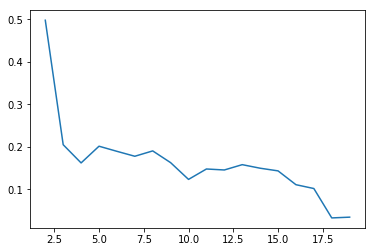

In [38]:
START = 2
END = 20
scores = []
for k in range(START, END):
    # run k-means clustering, but drop the first column (buurtcode)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Munich_grouped_clustering[Munich_grouped_clustering.columns[0:]])
    #scores.append(kmeans.inertia_)
    scores.append(metrics.silhouette_score(Munich_grouped_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

In [39]:
# set number of clusters
kclusters = 12

Munich_grouped_clustering = Munich_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:12] 

array([3, 0, 0, 1, 8, 9, 2, 2, 0, 0, 4, 2], dtype=int32)

In [40]:
Munich_data=boroughs_names_df.rename(columns= {'Boroughs' :'Neighborhood'})
Munich_data.head()

,Neighborhood,longitude,latitude,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2
0,Berg am Laim,11.623498,48.124306,6.31,45655,7.230,31.6,12.4
1,Schwanthalerhöhe,11.540085,48.136428,2.07,30282,14.628,34.7,15.2
2,Altstadt-Lehel,11.581973,48.141517,3.15,21454,6.820,27.4,15.3
3,Allach-Untermenzing,11.467160,48.195986,15.45,32248,2.087,22.0,12.0
4,Hadern,11.472252,48.115026,9.22,50567,5.482,27.3,12.8


In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Munich_merged = Munich_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Munich_merged = Munich_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Munich_merged.head() # check the last columns!

,Neighborhood,longitude,latitude,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2,Cluster Labels,1st Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Berg am Laim,11.623498,48.124306,6.31,45655,7.230,31.6,12.4,8.0,Grocery Store,...,Field,Yoga Studio,Fried Chicken Joint,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Drugstore,Donut Shop
1,Schwanthalerhöhe,11.540085,48.136428,2.07,30282,14.628,34.7,15.2,0.0,Café,...,Italian Restaurant,French Restaurant,Japanese Restaurant,Drugstore,Salad Place,Yoga Studio,Juice Bar,Bus Stop,Cocktail Bar,Grocery Store
2,Altstadt-Lehel,11.581973,48.141517,3.15,21454,6.820,27.4,15.3,0.0,Boutique,...,Supermarket,Italian Restaurant,Breakfast Spot,Restaurant,Art Museum,Opera House,Park,Palace,Camera Store,Convenience Store
3,Allach-Untermenzing,11.467160,48.195986,15.45,32248,2.087,22.0,12.0,3.0,Supermarket,...,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,Event Space,Ethiopian Restaurant,Electronics Store,Donut Shop,Doner Restaurant,Dim Sum Restaurant,Design Studio
4,Hadern,11.472252,48.115026,9.22,50567,5.482,27.3,12.8,2.0,Bus Stop,...,Ice Cream Shop,Asian Restaurant,Trattoria/Osteria,Bagel Shop,Fish Market,Fried Chicken Joint,French Restaurant,Food Service,Food Court,American Restaurant


In [42]:
Munich_merged = Munich_merged[Munich_merged.Neighborhood != 'Feldmoching-Hasenbergl']
Munich_merged = Munich_merged.astype({'Cluster Labels': int})


In [43]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Munich_merged['latitude'], Munich_merged['longitude'], Munich_merged['Neighborhood'], Munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
munich_map = folium.Map(location=[latitude, longitude], zoom_start=11)
fs = plugins.Fullscreen()
munich_map.add_child(fs)

folium.GeoJson('munich.geojson').add_to(munich_map)

munich_map.choropleth(
    geo_data='munich.geojson',
    name='Population Density',
    data=boroughs_names_df,
    columns=['Boroughs', 'Density (inhabitants/km^2)'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Density'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Munich_merged['latitude'], Munich_merged['longitude'], Munich_merged['Neighborhood'], Munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(munich_map)

munich_map

In [43]:
boroughs_names_df.head()

,Boroughs,longitude,latitude,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2
0,Berg am Laim,11.623498,48.124306,6.31,45655,7.230,31.6,12.4
1,Schwanthalerhöhe,11.540085,48.136428,2.07,30282,14.628,34.7,15.2
2,Altstadt-Lehel,11.581973,48.141517,3.15,21454,6.820,27.4,15.3
3,Allach-Untermenzing,11.467160,48.195986,15.45,32248,2.087,22.0,12.0
4,Hadern,11.472252,48.115026,9.22,50567,5.482,27.3,12.8


In [45]:
munich_map = folium.Map(location=[latitude, longitude], zoom_start=11)
fs = plugins.Fullscreen()
munich_map.add_child(fs)

folium.GeoJson('munich.geojson').add_to(munich_map)

munich_map.choropleth(
    geo_data='munich.geojson',
    name='Rent price EUR/m^2',
    data=boroughs_names_df,
    columns=['Boroughs', 'Rent price EUR/m^2'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Rent price EUR/m^2'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Munich_merged['latitude'], Munich_merged['longitude'], Munich_merged['Neighborhood'], Munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(munich_map)

munich_map

It is to note that the cluster 4 is correlated with high population densities so we check what is in this cluster


In [45]:
boroughs_names_df.head()

,Boroughs,longitude,latitude,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2
0,Berg am Laim,11.623498,48.124306,6.31,45655,7.230,31.6,12.4
1,Schwanthalerhöhe,11.540085,48.136428,2.07,30282,14.628,34.7,15.2
2,Altstadt-Lehel,11.581973,48.141517,3.15,21454,6.820,27.4,15.3
3,Allach-Untermenzing,11.467160,48.195986,15.45,32248,2.087,22.0,12.0
4,Hadern,11.472252,48.115026,9.22,50567,5.482,27.3,12.8


In [46]:
munich_map = folium.Map(location=[latitude, longitude], zoom_start=11)
fs = plugins.Fullscreen()
munich_map.add_child(fs)

folium.GeoJson('munich.geojson').add_to(munich_map)

munich_map.choropleth(
    geo_data='munich.geojson',
    name='Foreigners %',
    data=boroughs_names_df,
    columns=['Boroughs', 'Foreigners %'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Foreigners %'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Munich_merged['latitude'], Munich_merged['longitude'], Munich_merged['Neighborhood'], Munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(munich_map)

munich_map

In [47]:
munich_map = folium.Map(location=[latitude, longitude], zoom_start=11)
fs = plugins.Fullscreen()
munich_map.add_child(fs)

folium.GeoJson('munich.geojson').add_to(munich_map)

munich_map.choropleth(
    geo_data='munich.geojson',
    name='Inhabitants',
    data=boroughs_names_df,
    columns=['Boroughs', 'Inhabitants'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Inhabitants'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Munich_merged['latitude'], Munich_merged['longitude'], Munich_merged['Neighborhood'], Munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(munich_map)

munich_map

In [48]:
Munich_merged.head()

,Neighborhood,longitude,latitude,Surface (km^2),Inhabitants,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2,Cluster Labels,1st Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Berg am Laim,11.623498,48.124306,6.31,45655,7.230,31.6,12.4,8,Grocery Store,...,Field,Yoga Studio,Fried Chicken Joint,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Drugstore,Donut Shop
1,Schwanthalerhöhe,11.540085,48.136428,2.07,30282,14.628,34.7,15.2,0,Café,...,Italian Restaurant,French Restaurant,Japanese Restaurant,Drugstore,Salad Place,Yoga Studio,Juice Bar,Bus Stop,Cocktail Bar,Grocery Store
2,Altstadt-Lehel,11.581973,48.141517,3.15,21454,6.820,27.4,15.3,0,Boutique,...,Supermarket,Italian Restaurant,Breakfast Spot,Restaurant,Art Museum,Opera House,Park,Palace,Camera Store,Convenience Store
3,Allach-Untermenzing,11.467160,48.195986,15.45,32248,2.087,22.0,12.0,3,Supermarket,...,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,Event Space,Ethiopian Restaurant,Electronics Store,Donut Shop,Doner Restaurant,Dim Sum Restaurant,Design Studio
4,Hadern,11.472252,48.115026,9.22,50567,5.482,27.3,12.8,2,Bus Stop,...,Ice Cream Shop,Asian Restaurant,Trattoria/Osteria,Bagel Shop,Fish Market,Fried Chicken Joint,French Restaurant,Food Service,Food Court,American Restaurant


In [52]:
clusters = pd.DataFrame(Munich_merged.groupby('Cluster Labels', as_index=False).apply(lambda x: ", ".join(x['Neighborhood'].tolist())), columns=['Similar'])
clusters['Count'] = Munich_merged.groupby('Cluster Labels')['Neighborhood'].count()
print("Cluster | Count | Neighbourhoods")
print("--------|-------|---------------")
for x,y,z in zip(clusters.index,clusters['Count'],clusters['Similar']):
    print("{} | {} | {}".format(x,y,z))

Cluster | Count | Neighbourhoods
--------|-------|---------------
0 | 7 | Schwanthalerhöhe, Altstadt-Lehel, Au-Haidhausen, Pasing-Obermenzing, Ludwigsvorstadt-Isarvorstadt, Maxvorstadt, Schwabing-West
1 | 1 | Aubing-Lochhausen-Langwied
2 | 5 | Hadern, Moosach, Laim, Sendling-Westpark, Obergiesing-Fasangarten
3 | 2 | Allach-Untermenzing, Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
4 | 1 | Milbertshofen-Am Hart
5 | 1 | Neuhausen-Nymphenburg
6 | 1 | Trudering-Riem
7 | 1 | Ramersdorf-Perlach
8 | 1 | Berg am Laim
9 | 1 | Bogenhausen
10 | 1 | Untergiesing-Harlaching
11 | 1 | Schwabing-Freimann


# Cluster 0

In [53]:
Munich_merged.loc[Munich_merged['Cluster Labels'] == 0, Munich_merged.columns[[1] + list(range(5, Munich_merged.shape[1]))]]

,longitude,Density (inhabitants/km^2),Foreigners %,Rent price EUR/m^2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1,11.540085,14.628,34.7,15.2,0,Café,Bar,Pizza Place,Hotel,Ice Cream Shop,...,Italian Restaurant,French Restaurant,Japanese Restaurant,Drugstore,Salad Place,Yoga Studio,Juice Bar,Bus Stop,Cocktail Bar,Grocery Store
2,11.581973,6.820,27.4,15.3,0,Boutique,Plaza,Café,German Restaurant,Hotel,...,Supermarket,Italian Restaurant,Breakfast Spot,Restaurant,Art Museum,Opera House,Park,Palace,Camera Store,Convenience Store
5,11.596434,14.693,24.7,15.1,0,Italian Restaurant,Café,German Restaurant,Plaza,Bar,...,Burger Joint,Concert Hall,Asian Restaurant,Ice Cream Shop,Wine Bar,Hotel,Cocktail Bar,Bistro,Gourmet Shop,Drugstore
6,11.461062,4.512,22.4,12.9,0,Drugstore,Italian Restaurant,Café,Coffee Shop,Bakery,...,Clothing Store,Chinese Restaurant,Farmers Market,Bookstore,Mexican Restaurant,Gym / Fitness Center,Modern European Restaurant,Organic Grocery,Post Office,Electronics Store
7,11.563565,12.477,32.6,16.4,0,Café,Vietnamese Restaurant,Burger Joint,Bar,Hotel,...,Monument / Landmark,Restaurant,Camera Store,Plaza,Sandwich Place,Pizza Place,Boutique,Creperie,Deli / Bodega,Middle Eastern Restaurant
8,11.565119,12.435,27.9,15.2,0,Café,History Museum,Restaurant,Movie Theater,Art Museum,...,Roof Deck,Italian Restaurant,Pub,Plaza,Peruvian Restaurant,Chinese Restaurant,Coffee Shop,Grilled Meat Restaurant,Field,Burger Joint
9,11.582597,15.908,23.4,15.2,0,Café,Italian Restaurant,Coffee Shop,Bar,Thai Restaurant,...,German Restaurant,Vietnamese Restaurant,Plaza,Noodle House,Pizza Place,Grocery Store,Public Art,Indie Theater,Movie Theater,Music Venue


We see that the cluster 0 the one with the highest rent price is the zone that is mainly composed by restaurants and cafes, it is also the one with the highest density population.

# Cluster 2

In [61]:
Munich_merged.loc[Munich_merged['Cluster Labels'] == 2, Munich_merged.columns[[1] + list(range(8, Munich_merged.shape[1]))]]

,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
4,11.472252,2,Bus Stop,ATM,Bakery,Garden,Food & Drink Shop,Pharmacy,Post Office,Sandwich Place,...,Ice Cream Shop,Asian Restaurant,Trattoria/Osteria,Bagel Shop,Fish Market,Fried Chicken Joint,French Restaurant,Food Service,Food Court,American Restaurant
10,11.501373,2,Bakery,Drugstore,Supermarket,Hotel,Doner Restaurant,Motel,Bus Stop,Sandwich Place,...,Deli / Bodega,Hardware Store,Gym / Fitness Center,Gourmet Shop,Gym,Design Studio,Dim Sum Restaurant,History Museum,Donut Shop,Historic Site
12,11.504086,2,Bus Stop,Gastropub,Ice Cream Shop,Bank,Metro Station,Mobile Phone Shop,Supermarket,Tanning Salon,...,Plaza,Sandwich Place,Greek Restaurant,Hotel,Drugstore,American Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
18,11.532969,2,Hotel,Drugstore,Supermarket,Pet Store,Athletics & Sports,Bus Stop,Bakery,German Restaurant,...,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Falafel Restaurant,Fast Food Restaurant,Farmers Market,French Restaurant,Event Space,Ethiopian Restaurant
21,11.587845,2,Plaza,Bus Stop,Ice Cream Shop,Italian Restaurant,Pizza Place,Fruit & Vegetable Store,Yoga Studio,Falafel Restaurant,...,Field,Fast Food Restaurant,Farmers Market,Ethiopian Restaurant,Event Space,Food Court,Electronics Store,Drugstore,Donut Shop,Doner Restaurant


The cluster number 2 seems to be a  mix of locals as Supermarkets, Ice cream shops and Bakeries. All of these local are associated with families. SO it is to expect that this regions are more residential. Therefore is more convinient to open a supermarket in this regions than in that of the Cluster 0. Besides the cost of rent are lower.

# Cluster 5
Cluster 5 contains a Park and a palace that occupy most of its surface, and therefore explaining why it exceptionaly out of cluster 0 or 2. The cluster is clearly dominated by only retaurant which are intended for the visitors of the atraction in the region.

In [62]:
Munich_merged.loc[Munich_merged['Cluster Labels'] == 5, Munich_merged.columns[[1] + list(range(8, Munich_merged.shape[1]))]]

,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
14,11.520135,5,Italian Restaurant,Electronics Store,Canal,Yoga Studio,Farmers Market,Food Service,Food Court,Food & Drink Shop,...,Field,Fast Food Restaurant,Falafel Restaurant,Fried Chicken Joint,Event Space,Ethiopian Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dim Sum Restaurant


# Part 4/4

Conclusions

By stracting data of Munich such as denity, rent prices and foreign %, we can correlate this data woth the clusterisation of locals.

As shown in the map plots a correlation between the clusterization of the  
